In [5]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa
from lifelines import KaplanMeierFitter
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
def generate_features(num_samples):
    genders = np.random.randint(0, 2, num_samples)
    ages = np.random.gamma(15, 1.6, num_samples).round()
    nums_friends = np.random.gamma(3, 10, num_samples).round()
    nums_liked = np.random.gamma(5, 30, num_samples).round()
    nums_calls = np.multiply(nums_friends, np.random.normal(15, 2, num_samples).clip(1)).round()
    
    return pd.DataFrame({
        'gender': genders,
        'age': ages,
        'num_friends': nums_friends,
        'num_liked': nums_liked,
        'num_calls': nums_calls
    })

def get_normal_prob(mean, stdev):
    return np.clip(np.random.normal(mean, stdev), 0.1, 0.99)

def get_death_prob(t, features):
    zipped = pd.DataFrame({
        'gender': features['gender'].apply(
            lambda x:
                get_normal_prob(0.9, 0.01) if x == 0
                else get_normal_prob(0.85, 0.01)
        ),
        'age' : features['age'].apply(
            lambda x: ((0 <= x < 10 and get_normal_prob(0.7, 0.02)) or
                       (10 <= x < 20 and get_normal_prob(0.85, 0.03)) or
                       (20 <= x < 30 and get_normal_prob(0.9, 0.05)) or
                       (30 <= x < 40 and get_normal_prob(0.75, 0.05)) or
                       (40 <= x < 50 and get_normal_prob(0.7, 0.05)) or            
                       get_normal_prob(0.2, 0.05)) - np.random.normal(0.02 * np.log(t), 0.005)
        ),
        'num_friends': features['num_friends'].apply(
            lambda x: np.clip(np.log(max(1, x)) * 0.2, 0.1, 0.99)
        ),
        'num_liked': features['num_liked'].apply(
            lambda x: np.clip(np.log(max(1, x)) * (1/6), 0.1, 0.99)
        ),
        'num_calls': features['num_calls'].apply(
            lambda x: np.clip(np.log(max(1, x)) * (1/8) + np.random.normal(0.03 * np.log(t), 0.005), 0.1, 0.99)
        )
    })
    
    return zipped['gender'] * 0.3 + zipped['age'] * 0.35 + zipped['num_friends'] * 0.05 + zipped['num_liked'] * 0.05 + zipped['num_calls'] * 0.25

def generate_dataset(num_samples, death_threshold, max_time):
    data = generate_features(num_samples)
    data['event'] = False
    data['time'] = 1
    time = 1
    
    while time < max_time:
        time = time + 1
        prob = get_death_prob(time, data)
        data['time'] = data['time'] + ~(data['event'] | (prob < death_threshold)) * 1
        data['event'] = data['event'] | (prob < death_threshold)

    return data

<AxesSubplot:xlabel='time (day)', ylabel='survival function, $\\hat{S}(t)$'>

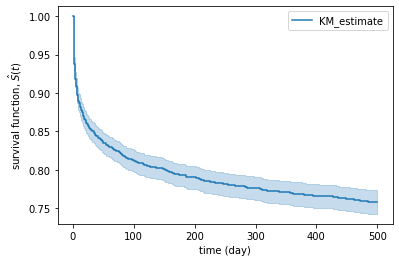

In [3]:
data = generate_dataset(3000, 0.75, 500)

kmf = KaplanMeierFitter()
kmf.fit(data["time"], data["event"])

plot = kmf.plot_survival_function()
plot.set_xlabel('time (day)')
plot.set_ylabel('survival function, $\hat{S}(t)$')
plot

In [6]:
X = data.drop(data.columns[-2:], axis=1)
y = data.apply(lambda x: (x.event, x.time), axis=1).to_numpy(dtype=[('event', 'bool'), ('time', 'float64')])

In [7]:
gbr = GradientBoostingSurvivalAnalysis()
gbr_gcv = GridSearchCV(gbr, {}, cv=KFold(n_splits=5))
gbr_result = gbr_gcv.fit(X, y)
print('C-index = ', gbr_result.best_score_)

C-index =  0.9623245231016038


In [8]:
data

,gender,age,num_friends,num_liked,num_calls,event,time
0,0,20.0,48.0,48.0,735.0,False,500
1,0,22.0,29.0,159.0,422.0,False,500
2,1,30.0,18.0,356.0,293.0,True,2
3,0,25.0,11.0,53.0,171.0,False,500
4,1,18.0,14.0,145.0,209.0,True,206
...,...,...,...,...,...,...,...
2995,1,25.0,6.0,42.0,57.0,True,1
2996,0,26.0,31.0,130.0,506.0,False,500
2997,0,34.0,63.0,150.0,1074.0,False,500
2998,0,27.0,23.0,127.0,319.0,False,500
